In [6]:
# à mettre dans le terminal
# pip install gdown
# gdown https://drive.google.com/uc?id=1PkZYDUtgH-dRBPssB1U6OzQBikV6mVCb

import pandas as pd


# Lecture des 5 premières lignes du fichier
df = pd.read_csv("list_cpc_patent_EP.csv", nrows=10)
print(df)
# la table des brevets contient 29 779 374 lignes

df = pd.read_csv("list_cpc_patent_EP.csv")
#on compte le nb de lignes dans la table
n_avant = len(df)

# Étape 1 : on supprime les doublons exacts (si même brevet + même CPC apparaissent plusieurs fois)
df_unique = df.drop_duplicates(subset=["publication_number", "CPC4"])

n_apres = len(df_unique)
nb_doublons = n_avant - n_apres

print(f"Nombre de lignes avant suppression des doublons : {n_avant}")
print(f"Nombre de lignes après suppression des doublons  : {n_apres}")
print(f"Nombre de doublons supprimés                     : {nb_doublons}")

# Nombre de lignes avant suppression des doublons : 29 779 373
# Nombre de lignes après suppression des doublons  : 5 401 265
# Nombre de doublons supprimés                     : 24 378 108
# Nombre de brevets avec plusieurs CPC : 1524689

#  Étape 2 : on compte le nombre de codes CPC distincts par brevet
cpc_counts = df_unique.groupby("publication_number")["CPC4"].nunique().reset_index(name="nb_cpc")

# Étape 3 : on filtre les brevets avec plusieurs codes CPC
multi_cpc = cpc_counts[cpc_counts["nb_cpc"] > 1]

# Étape 4 : on fait une jointure pour voir le détail des codes CPC correspondants
multi_cpc_details = df_unique[df_unique["publication_number"].isin(multi_cpc["publication_number"])]

# afficher un aperçu
print("Nombre de brevets avec plusieurs CPC :", multi_cpc.shape[0])
print(multi_cpc_details.head(10))
# Nombre de brevets avec plusieurs CPC : 1 524 689

# On regroupe les codes CPC par brevet sous forme de liste
cpc_list = (
    df_unique
    .groupby("publication_number")["CPC4"]
    .apply(list)
    .reset_index(name="liste_CPC")
)

# On garde uniquement les brevets avec plusieurs CPC
multi_cpc_list = cpc_list[cpc_list["liste_CPC"].apply(lambda x: len(x) > 1)]

print("Nombre de brevets avec plusieurs CPC :", multi_cpc_list.shape[0])
print(multi_cpc_list.head(10))
multi_cpc_list.to_csv("brevets_multicpc.csv", index=False)


df_multi_cpc = pd.read_csv("brevets_multicpc.csv", nrows=20)
print(df_multi_cpc)
n_multi = len(df_multi_cpc)
print(n_multi)

filename = "brevets_multicpc.csv"

with open(filename, "r", encoding="utf-8") as f:
    n_lines = sum(1 for _ in f) - 1  # on enlève 1 pour l'en-tête

print(f"Nombre de brevets multiclassés : {n_lines}")

# Nombre de brevets multiclassés : 1 524 689


# Analyse statistique de la répartition des sections parmi les brevets

# On part de df_unique qui contient les brevets uniques par (publication_number, CPC4)

# 1. Extraire la section (première lettre du code CPC4)
df_unique["section"] = df_unique["CPC4"].str[0]

# 2. Compter le nombre de brevets par section
counts = df_unique["section"].value_counts().sort_index()

# 3. Calculer le pourcentage
percentages = 100 * counts / counts.sum()

# 4. Afficher le résultat
result = pd.DataFrame({"count": counts, "percentage": percentages})
print(result)



FileNotFoundError: [Errno 2] No such file or directory: 'list_cpc_patent_EP.csv'

In [ ]:


# graphes


import matplotlib.pyplot as plt


# Graphique en camembert
plt.figure(figsize=(8, 8))
plt.pie(
    counts,
    labels=counts.index,
    autopct="%1.1f%%",
    startangle=140,
    colors=plt.cm.tab20.colors
)
plt.title("Répartition des sections CPC (camembert)")
plt.axis("equal")  # Pour que le cercle soit rond
plt.show()

# Histogramme 
plt.figure(figsize=(10, 6))
counts.plot(kind="bar", color="skyblue")
plt.title("Nombre de brevets par section CPC")
plt.xlabel("Section CPC")
plt.ylabel("Nombre de brevets")
plt.xticks(rotation=0)
plt.show()



In [4]:

# Analyse des combinaisons fréquentes de codes CPC à partir de brevets_multicpc.csv

import ast

# On charge le fichier
df = pd.read_csv("brevets_multicpc.csv")

# La colonne liste_CPC est en format string (ex : "['A61K', 'A61P', 'C07D']")
# On la convertit en liste Python
df['liste_CPC'] = df['liste_CPC'].apply(ast.literal_eval)

print(df.head())

# Pour commencer, on peut extraire la classe CPC (lettre + 2 chiffres) pour réduire la granularité :
def extract_classe(cpc_code):
    # Exemple: 'A61K' -> 'A61', 'G06F' -> 'G06'
    return cpc_code[:3]

df['liste_classes'] = df['liste_CPC'].apply(lambda codes: list(set(extract_classe(c) for c in codes)))

print(df[['liste_CPC', 'liste_classes']].head())

# Construction de la matrice d’occurrence des classes CPC
# On veut savoir quelles classes apparaissent souvent ensemble.
# Pour cela, on va : 
# 1) lister toutes les classes distinctes
# 2) pour chaque brevet, noter la présence ou absence de chaque classe
# construire une matrice binaire (brevet x classe)

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
X = mlb.fit_transform(df['liste_classes'])

df_matrix = pd.DataFrame(X, columns=mlb.classes_)

print(df_matrix.head())

# Calcul de la matrice de co-occurrence
# La matrice de co-occurrence est une matrice carrée où l’élément (i,j) indique
#  combien de brevets ont à la fois la classe i et la classe j
cooccurrence = df_matrix.T.dot(df_matrix)

print(cooccurrence)

# on identifie les associations fréquentes
# Les valeurs diagonales indiquent le nombre de brevets contenant chaque classe.
# Les valeurs hors diagonale indiquent le nombre de brevets contenant les deux classes ensemble.
# On peut par exemple extraire les paires (i,j) avec un seuil minimal pour repérer les associations fortes :

threshold = 1000  # Ajuste ce seuil selon la taille de ta base

cooccurrence_pairs = []

for i, classe_i in enumerate(cooccurrence.index):
    for j, classe_j in enumerate(cooccurrence.columns):
        if i < j:  # pour ne pas doubler les paires (i,j) et (j,i)
            val = cooccurrence.iloc[i,j]
            if val >= threshold:
                cooccurrence_pairs.append((classe_i, classe_j, val))

# Trier par co-occurrence décroissante
cooccurrence_pairs = sorted(cooccurrence_pairs, key=lambda x: x[2], reverse=True)

# Afficher les 10 premières associations fréquentes
print("Top 10 des associations fréquentes de classes CPC :")
for c1, c2, val in cooccurrence_pairs[:10]:
    print(f"{c1} & {c2} : {val} brevets")




  publication_number                                          liste_CPC
0      EP-0000001-B1  [C07C, B60L, F25B, A99Z, F24S, F28D, C08L, A61...
1      EP-0000002-B1                                 [C07D, A01N, F01D]
2      EP-0000004-B1                                       [B04B, A47J]
3      EP-0000005-B1                                       [C07D, A61P]
4      EP-0000006-B1                                       [C02F, Y02W]
                                           liste_CPC  \
0  [C07C, B60L, F25B, A99Z, F24S, F28D, C08L, A61...   
1                                 [C07D, A01N, F01D]   
2                                       [B04B, A47J]   
3                                       [C07D, A61P]   
4                                       [C02F, Y02W]   

                              liste_classes  
0  [F24, B60, C07, F28, F25, C08, A99, A61]  
1                           [F01, C07, A01]  
2                                [B04, A47]  
3                                [C07, A61]  
4

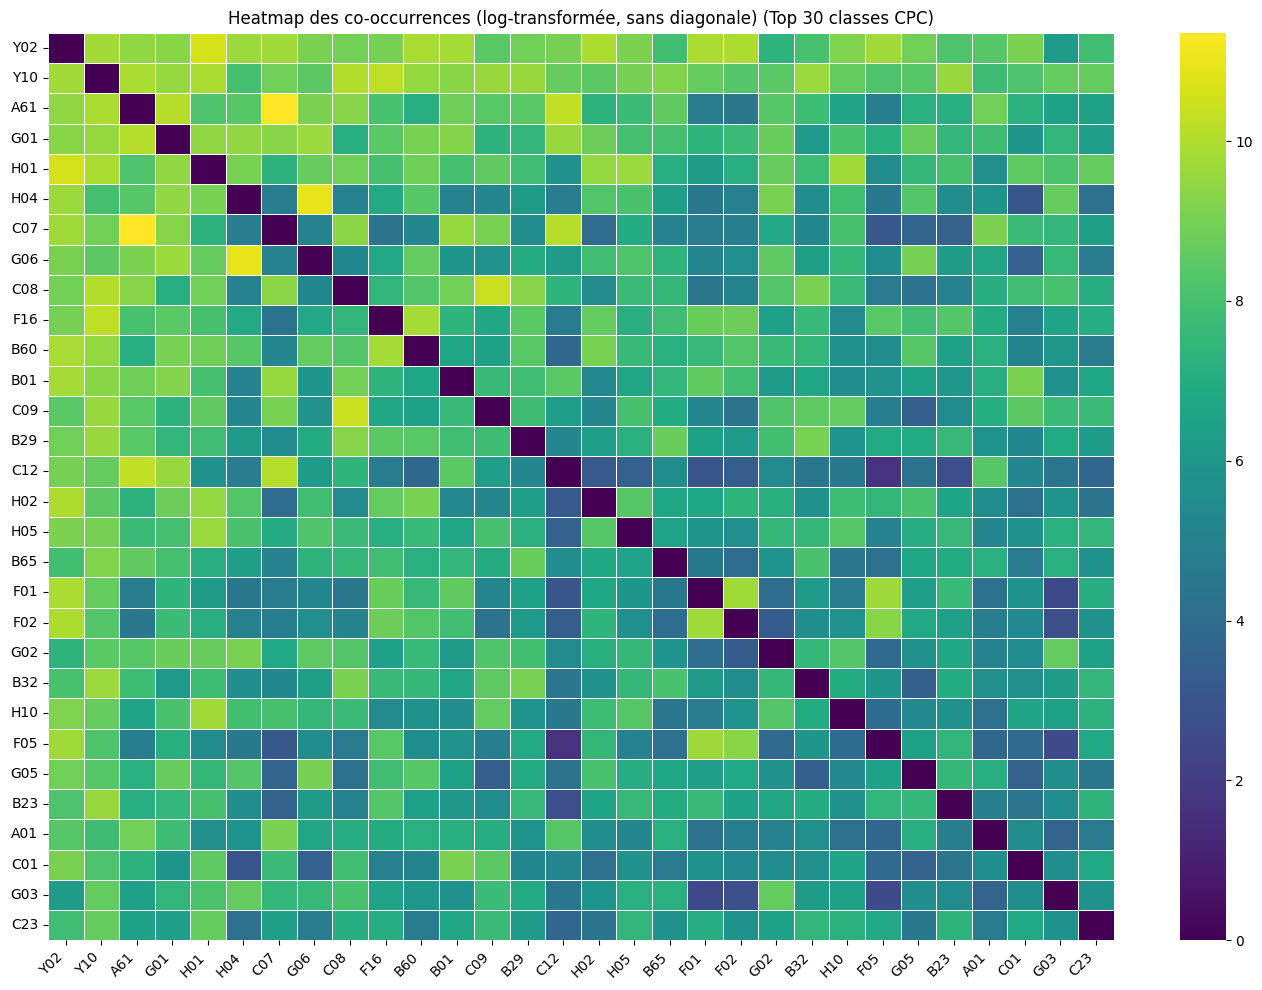

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cooc_no_diag = cooc_top.copy()
np.fill_diagonal(cooc_no_diag.values, 0)

cooc_log = np.log1p(cooc_no_diag)

plt.figure(figsize=(14, 10))
sns.heatmap(cooc_log, cmap="viridis", linewidths=0.5)
plt.title(f"Heatmap des co-occurrences (log-transformée, sans diagonale) (Top {N} classes CPC)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


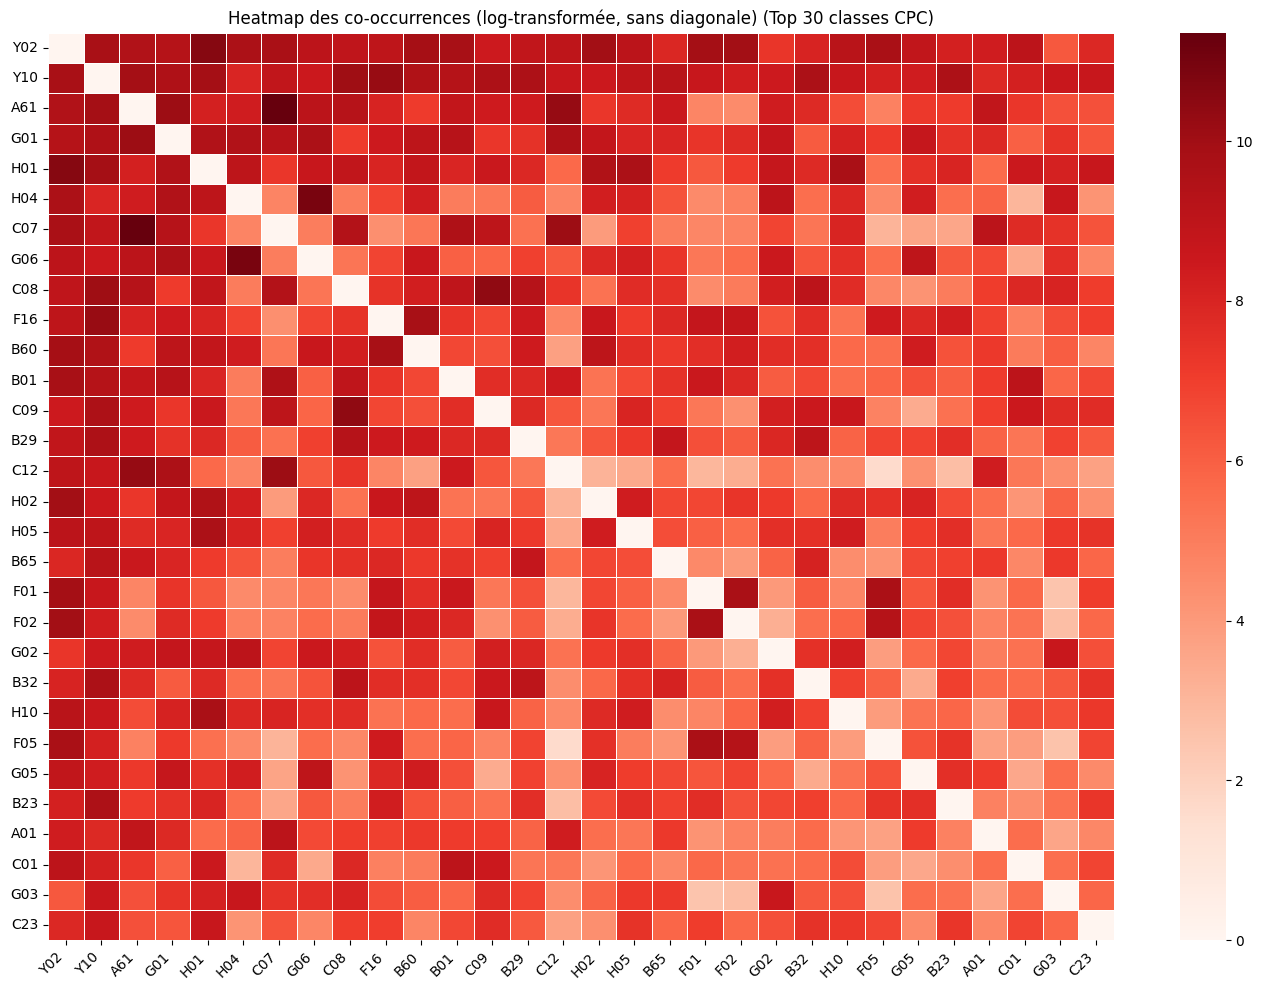

In [11]:
plt.figure(figsize=(14, 10))
sns.heatmap(cooc_log, cmap="Reds", linewidths=0.5)
plt.title(f"Heatmap des co-occurrences (log-transformée, sans diagonale) (Top {N} classes CPC)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
# CALCUL DU SCORE D'ORIGINALITÉ

cooc = cooccurrence.copy().astype(float)

# Marges
row_sum = cooc.sum(axis=1)
col_sum = cooc.sum(axis=0)
N = cooc.values.sum()

# Matrice des co-occurrences attendues
expected = np.outer(row_sum, col_sum) / N
expected = pd.DataFrame(expected, index=cooc.index, columns=cooc.columns)

# Pour éviter les 0 → on met un epsilon
epsilon = 1e-9
expected = expected.replace(0, epsilon)

# Score d'originalité
originality = cooc / expected

print(originality.head())

# Cette matrice indique si les couples sont plus fréquents que prévu ( > 1 ) ou moins fréquents ( < 1 ).


           A01         A21         A22        A23         A24       A41  \
A01  42.102876    0.319672    2.088806   2.388823    0.270519  0.320166   
A21   0.319672  430.597416   12.154714  35.720634    0.174222  0.000000   
A22   2.088806   12.154714  892.517950  15.636483    0.000000  0.442350   
A23   2.388823   35.720634   15.636483  66.925282    2.111881  0.032825   
A24   0.270519    0.174222    0.000000   2.111881  306.039673  0.000000   

          A42       A43       A44       A45  ...  G99       H01       H02  \
A01  0.291803  0.117336  0.395067  0.768537  ...  0.0  0.083462  0.160825   
A21  0.000000  0.000000  0.000000  0.000000  ...  0.0  0.011862  0.019807   
A22  0.000000  0.000000  0.205886  0.742419  ...  0.0  0.039896  0.063444   
A23  0.053601  0.015675  0.015278  0.055091  ...  0.0  0.025375  0.015065   
A24  0.000000  0.072668  0.212479  0.681063  ...  0.0  0.496041  1.353160   

          H03       H04       H05       H10       Y02       Y04       Y10  
A01  0.052

In [ ]:
# INDICE DE CONVERGENCE PAR ENTROPIE

# On vectorise les valeurs hors-diagonale
vals = cooc.values
triu_idx = np.triu_indices_from(vals, k=1)
v = vals[triu_idx]

# Probas
p = v / v.sum()

# Entropie de Shannon
entropy = -np.sum(p * np.log(p + epsilon))

# Normalisation (max entropy = log(nb_paires))
max_entropy = np.log(len(p))

ICT_entropy = entropy / max_entropy

print("Indice ICT (entropie normalisée) :", ICT_entropy)

# Un indice entre 0 et 1 : 0 = technologies cloisonnées / 1 = recombinaisons très diversifiées


Indice ICT (entropie normalisée) : 0.7509047879159031


In [ ]:
# importation du fichier de Quentin
import pandas as pd
base_CPC = pd.read_parquet("patents_merged.parquet")

base_CPC.head() 
# len(base_CPC) # 309 781 lignes


,doc7,doc_number,ep_doc,publication_date,cpc4_list,person_id_list,app_name_list,address_list,city_list,postal_code_list,reg_code_list,ctry_code_list,reg_share_list,app_share_list,num_applicants
0,0167731,167731,EP-0167731,19880907,[C08G],"[630346, 11234, 22776, 49295585, 51194965, 178...","[Comelit Group S.p.a., NGK Insulators, Ltd., G...","[Via Don Arrigoni 5,24020 Rovetta San Lorenzo ...","[San Lorenzo, Aichi, Albstadt, Tokyo, Greifens...","[24020, 467, 72458, 108, 8606, 56070, 10365, 5...","[ITC46, JPF23, DE143, JPD13, CH040, DEB11, SE1...","[IT, JP, DE, JP, CH, DE, SE, JP, US, DE, DE, US]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",12
1,0719740,719740,EP-0719740,19990519,"[C03C, Y10S]","[1357945, 80365, 1095194, 101435, 51193962, 17...","[GEA Food Solutions Germany GmbH, Yale Univers...","[Im Ruttert,35216 Biedenkopf-Wallau, Two Whitn...","[Biedenkopf, None, Strand, Oberdorf, Leverkuse...","[35216, 06511, WC2R2LS, 4436, 51373, 19101, V6...","[DE724, US09009, UKJ13, CH032, DEA24, US42101,...","[DE, US, GB, CH, DE, US, CA, DE, NL, AT, US, J...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",15
2,0719776,719776,EP-0719776,19981104,"[A61K, C07D, A61P]","[4529, 3542266, 48039808, 3772, 464889, 24625,...",[Shell Internationale Research Maatschappij B....,"[Carel van Bylandtlaan 30,2596 HR Den Haag, We...","[Den Haag, Oberndorf, Paris, Beerse, ISTANBUL,...","[2596, 78727, 75008, 2340, 34950, None, 20100,...","[NL332, DE135, FR101, BE213, TR100, LU000, FI1...","[NL, DE, FR, BE, TR, LU, FI, US, US]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",9
3,0720104,720104,EP-0720104,20020828,[G06F],"[27949, 512922, 17668, 548006, 51180931, 19180...","[Marel Stork Poultry Processing B.V., IBIDEN C...","[Handelstraat 3,5831 AV Boxmeer, 1, Kanda-cho ...","[Boxmeer, gifu ken, Ingolstadt, Odense, Hattin...","[5831, 503, 85045, 5230, 45525, 6545, 1214, 77...","[NL413, JPF21, DE211, DK031, DEA56, NL226, CH0...","[NL, JP, DE, DK, DE, NL, CH, US, FR, US, SE, U...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",15
4,0167770,167770,EP-0167770,19880817,[C07D],"[49652998, 49855390, 5024, 8582, 4970, 6990698...","[Canon Kabushiki Kaisha, Transport Logistics I...","[30-2, Shimomaruko 3-chome,Ohta-ku,Tokyo 146-8...","[Tokyo, None, None, WATERLOO, CHICAGO, Eindhov...","[146, 20759, 12345, N2L3W8, 1596, 5656, 918, 8...","[JPD13, US24027, US36093, CA3530, US17031, NL4...","[JP, US, US, CA, US, NL, JP, CH, FR, CA, IT, D...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",13


In [ ]:
# on crée une base_multi qui ne conserve que les lignes des brevets qui ont plusieurs codes CPC
base_multi = base_CPC[base_CPC["cpc4_list"].apply(len) > 1].copy()


In [ ]:

base_multi.head()


,doc7,doc_number,ep_doc,publication_date,cpc4_list,person_id_list,app_name_list,address_list,city_list,postal_code_list,reg_code_list,ctry_code_list,reg_share_list,app_share_list,num_applicants
1,0719740,719740,EP-0719740,19990519,"[C03C, Y10S]","[1357945, 80365, 1095194, 101435, 51193962, 17...","[GEA Food Solutions Germany GmbH, Yale Univers...","[Im Ruttert,35216 Biedenkopf-Wallau, Two Whitn...","[Biedenkopf, None, Strand, Oberdorf, Leverkuse...","[35216, 06511, WC2R2LS, 4436, 51373, 19101, V6...","[DE724, US09009, UKJ13, CH032, DEA24, US42101,...","[DE, US, GB, CH, DE, US, CA, DE, NL, AT, US, J...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",15
2,0719776,719776,EP-0719776,19981104,"[A61K, C07D, A61P]","[4529, 3542266, 48039808, 3772, 464889, 24625,...",[Shell Internationale Research Maatschappij B....,"[Carel van Bylandtlaan 30,2596 HR Den Haag, We...","[Den Haag, Oberndorf, Paris, Beerse, ISTANBUL,...","[2596, 78727, 75008, 2340, 34950, None, 20100,...","[NL332, DE135, FR101, BE213, TR100, LU000, FI1...","[NL, DE, FR, BE, TR, LU, FI, US, US]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",9
6,0846888,846888,EP-0846888,20030813,"[Y10S, F16H]","[48137948, 369846, 4387578, 4285261, 49683332,...","[Gardner Denver Inc., Osaka Prefecture Univers...","[222 East Erie Street,Milwaukee, WI 53202, 1-1...","[None, osaka, osaka, Aichi, None, Gyeonggi do,...","[53202, 599, 541, 471, 80528, None, 53511, 219...","[US55079, JPG27, JPG27, JPF23, US08069, KR013,...","[US, JP, JP, JP, US, KR, US, ZA, HK]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",9
7,0846899,846899,EP-0846899,20030827,"[Y10T, B60K, F16H]","[49749440, 5993, 1235]","[Samsung Electronics Co., Ltd., Olympus Corpor...","[129, Samsung-ro,Yeongtong-gu,Suwon-si, Gyeong...","[Gyeonggi do, Tokyo, Hamburg]","[443742, 151, 21129]","[KR013, JPD13, DE600]","[KR, JP, DE]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]",3
8,0846906,846906,EP-0846906,20010725,"[F16B, Y10T, F16L]","[1717384, 48047455, 48082922, 49332326, 513454...","[Aktiebolaget SKF, Lund, Thore, Rydèn, Karin, ...","[41 550 Göteborg, Lundgatan 14,416 61 Göteborg...","[GoTEBORG, Goteborg, Goteborg, SEATTLE, Gyeong...","[41550, 41661, 41658, 1226, None, 530, 40503, ...","[SE232, SE232, SE232, US53033, KR013, JPG27, S...","[SE, SE, SE, US, KR, JP, SE, FR, JP]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.333333333333333, 0.333333333333333, 0.33333...",9


In [ ]:
len(base_CPC), len(base_multi) # on n'a plus que 169 330 brevets

(309781, 169330)

In [18]:
base_multi.to_parquet("patents_multi_cpc.parquet", index=False)



In [21]:
nb_codes_multi = base_multi["cpc4_list"].apply(len)
nb_codes_multi.value_counts().sort_index()



cpc4_list
2     97341
3     44346
4     17229
5      6435
6      2488
7       865
8       363
9       129
10       59
11       31
12       14
13        5
14       11
15        5
16        4
17        1
21        1
22        2
26        1
Name: count, dtype: int64

In [ ]:
(nb_codes_multi.value_counts(normalize=True)
               .sort_index()
               .mul(100)
               .round(2))
# parmi les brevets avec plus que 1 code CPC, 57% en ont 2, 26% en ont 3, 10% 4, 3,8% 5

cpc4_list
2     57.49
3     26.19
4     10.17
5      3.80
6      1.47
7      0.51
8      0.21
9      0.08
10     0.03
11     0.02
12     0.01
13     0.00
14     0.01
15     0.00
16     0.00
17     0.00
21     0.00
22     0.00
26     0.00
Name: proportion, dtype: float64

In [ ]:
# on compare avec la base complète 
nb_codes_all = base_CPC["cpc4_list"].apply(len)

# distribution brute
nb_codes_all.value_counts().sort_index()

# en pourcentage
(nb_codes_all.value_counts(normalize=True)
              .sort_index()
              .mul(100)
              .round(2))
# 45% des brevets ont 1 code, 31% en ont 2, 14% 3, ....

cpc4_list
1     45.34
2     31.42
3     14.32
4      5.56
5      2.08
6      0.80
7      0.28
8      0.12
9      0.04
10     0.02
11     0.01
12     0.00
13     0.00
14     0.00
15     0.00
16     0.00
17     0.00
21     0.00
22     0.00
26     0.00
Name: proportion, dtype: float64

In [25]:
import ast
# La colonne cpc4_list est en format string (ex : "['A61K', 'A61P', 'C07D']")
# On la convertit en liste Python
base_multi['cpc4_list'] = base_multi['cpc4_list'].apply(ast.literal_eval)

print(base_multi.head())

# Pour commencer, on peut extraire la classe CPC (lettre + 2 chiffres) pour réduire la granularité :
def extract_classe(cpc_code):
    # Exemple: 'A61K' -> 'A61', 'G06F' -> 'G06'
    return cpc_code[:3]

base_multi['liste_classes'] = base_multi['cpc4_list'].apply(lambda codes: list(set(extract_classe(c) for c in codes)))

print(base_multi[['cpc4_list', 'liste_classes']].head())

ValueError: malformed node or string: array(['C03C', 'Y10S'], dtype=object)

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer


# 1) Extraction de la classe CPC (3 premiers caractères)


def extract_classe(cpc_code):
    """Ex: 'A61K' → 'A61'."""
    return cpc_code[:3]

# cpc4_list contient des arrays → on convertit proprement en liste Python
base_multi["cpc_list_py"] = base_multi["cpc4_list"].apply(lambda x: list(x))

# Liste des classes CPC (une liste unique par brevet)
base_multi["liste_classes"] = base_multi["cpc_list_py"].apply(
    lambda codes: list(set(extract_classe(c) for c in codes))
)

print(base_multi[["cpc_list_py", "liste_classes"]].head())


          cpc_list_py    liste_classes
1        [C03C, Y10S]       [Y10, C03]
2  [A61K, C07D, A61P]       [A61, C07]
6        [Y10S, F16H]       [F16, Y10]
7  [Y10T, B60K, F16H]  [B60, Y10, F16]
8  [F16B, Y10T, F16L]       [F16, Y10]


In [28]:
# -------------------------
# 2) Construction de la matrice binaire brevet × classe
# -------------------------

mlb = MultiLabelBinarizer()
X = mlb.fit_transform(base_multi["liste_classes"])

df_matrix = pd.DataFrame(X, columns=mlb.classes_)

print("Aperçu de la matrice binaire brevet × classes :")
print(df_matrix.head())


Aperçu de la matrice binaire brevet × classes :
   A01  A21  A22  A23  A24  A41  A42  A43  A44  A45  ...  G21  H01  H02  H03  \
0    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   H04  H05  H10  Y02  Y04  Y10  
0    0    0    0    0    0    1  
1    0    0    0    0    0    0  
2    0    0    0    0    0    1  
3    0    0    0    0    0    1  
4    0    0    0    0    0    1  

[5 rows x 130 columns]


In [29]:
# -------------------------
# 3) Matrice de co-occurrence des classes CPC
# -------------------------

cooccurrence = df_matrix.T.dot(df_matrix)

print("Matrice de co-occurrence (extrait) :")
print(cooccurrence.head())


Matrice de co-occurrence (extrait) :
      A01  A21  A22   A23  A24  A41  A42  A43  A44  A45  ...  G21  H01  H02  \
A01  4539    1   10   142    2    2    1    0    1    6  ...    1   22    8   
A21     1  440    4   241    0    0    0    0    0    0  ...    0    0    1   
A22    10    4  213    31    0    0    0    0    0    0  ...    0    1    0   
A23   142  241   31  2627   28    0    0    0    0    2  ...    1    2    1   
A24     2    0    0    28  231    0    0    0    1    1  ...    0    1    1   

     H03  H04  H05  H10  Y02  Y04  Y10  
A01    2    4    7    1  334    0  519  
A21    0    0    8    0   14    0   46  
A22    0    0    0    0    3    0   78  
A23    1    2   15    1  141    0  396  
A24    0    0    4    0    1    0   56  

[5 rows x 130 columns]


In [30]:
# -------------------------
# 4) Extraction des paires de classes les plus fréquentes
# -------------------------

threshold = 1000   # règle ce seuil selon ta base (ex: 500 ou 2000)
cooccurrence_pairs = []

for i, classe_i in enumerate(cooccurrence.index):
    for j, classe_j in enumerate(cooccurrence.columns):
        if i < j:  # éviter doublons
            val = cooccurrence.iloc[i, j]
            if val >= threshold:
                cooccurrence_pairs.append((classe_i, classe_j, val))

# trier par valeur décroissante
cooccurrence_pairs = sorted(cooccurrence_pairs, key=lambda x: x[2], reverse=True)

print("\nTop 10 des associations CPC les plus fréquentes :")
for c1, c2, val in cooccurrence_pairs[:10]:
    print(f"{c1} & {c2} : {val} brevets")



Top 10 des associations CPC les plus fréquentes :
A61 & C07 : 11126 brevets
F16 & Y10 : 4433 brevets
C08 & Y10 : 4407 brevets
C08 & C09 : 3977 brevets
A61 & Y10 : 3781 brevets
H01 & Y10 : 3490 brevets
C07 & C12 : 2980 brevets
G01 & Y10 : 2810 brevets
A61 & C12 : 2600 brevets
H01 & Y02 : 2526 brevets


In [31]:
cooccurrence.to_csv("matrice_cooccurrence_cpc.csv")


In [32]:
# on installe networkx et matplotlib pour faire des graphes de co-occurence*
import networkx as nx
import matplotlib.pyplot as plt

# je pars du principe que tu as déjà la matrice cooccurrence
# cooccurrence : DataFrame carrée, index = colonnes = classes CPC (ex : 'A61', 'C07', ...)

# --------- paramètres à ajuster ----------
threshold = 500   # seuil minimum de co-occurence pour afficher une arête (à adapter à ta base)
# -----------------------------------------


# 1) Créer un graphe non orienté
G = nx.Graph()

# 2) Ajouter les nœuds avec une info de "taille" = fréquence de la classe (diagonale)
for classe in cooccurrence.index:
    freq = cooccurrence.loc[classe, classe]  # nb de brevets contenant cette classe
    G.add_node(classe, freq=freq)

# 3) Ajouter les arêtes pour les paires de classes qui co-apparaissent souvent
for i, ci in enumerate(cooccurrence.index):
    for j, cj in enumerate(cooccurrence.columns):
        if i < j:  # éviter doublons i,j et j,i
            w = cooccurrence.iloc[i, j]
            if w >= threshold:
                G.add_edge(ci, cj, weight=w)


Nombre de nœuds : 130
Nombre d'arêtes : 103


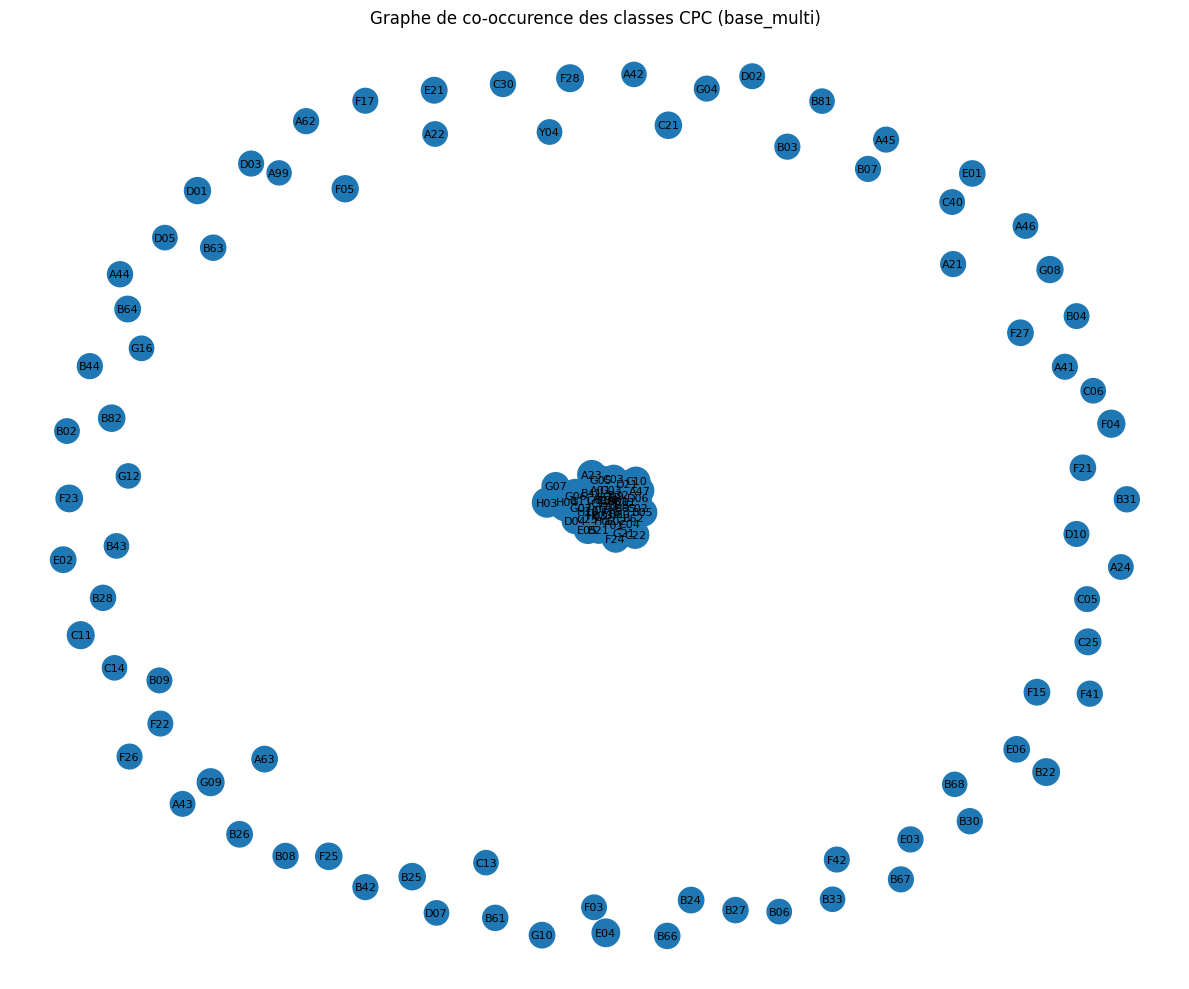

In [33]:
# Si le graphe est trop dense, tu peux vérifier rapidement :
print(f"Nombre de nœuds : {G.number_of_nodes()}")
print(f"Nombre d'arêtes : {G.number_of_edges()}")

# 4) Calculer une disposition (layout)
pos = nx.spring_layout(G, k=0.5, seed=0)  # layout "force-based"

# 5) Taille des nœuds proportionnelle à leur fréquence
freqs = nx.get_node_attributes(G, "freq")
max_freq = max(freqs.values()) if freqs else 1

node_sizes = [300 + 1700 * (freqs[n] / max_freq) for n in G.nodes()]  # entre ~300 et 2000

# 6) Poids des arêtes proportionnel à la co-occurence
weights = nx.get_edge_attributes(G, "weight")
max_w = max(weights.values()) if weights else 1
edge_widths = [0.5 + 4 * (weights[edge] / max_w) for edge in G.edges()]

# 7) Dessin du graphe
plt.figure(figsize=(12, 10))

nx.draw_networkx_nodes(G, pos, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Graphe de co-occurence des classes CPC (base_multi)")
plt.axis("off")
plt.tight_layout()
plt.show()


In [35]:
import networkx as nx
import matplotlib.pyplot as plt

# On part du graphe G déjà construit avec les poids "weight"

# 1) Enlever les nœuds isolés (degré 0)
nodes_with_edges = [n for n, d in G.degree() if d > 0]
G2 = G.subgraph(nodes_with_edges).copy()

print("Graphe filtré :")
print("  nœuds :", G2.number_of_nodes())
print("  arêtes :", G2.number_of_edges())


Graphe filtré :
  nœuds : 49
  arêtes : 103


In [36]:
# Si tu veux encore simplifier le graphe :
components = sorted(nx.connected_components(G2), key=len, reverse=True)
G_main = G2.subgraph(components[0]).copy()

print("Plus grande composante :")
print("  nœuds :", G_main.number_of_nodes())
print("  arêtes :", G_main.number_of_edges())


Plus grande composante :
  nœuds : 49
  arêtes : 103


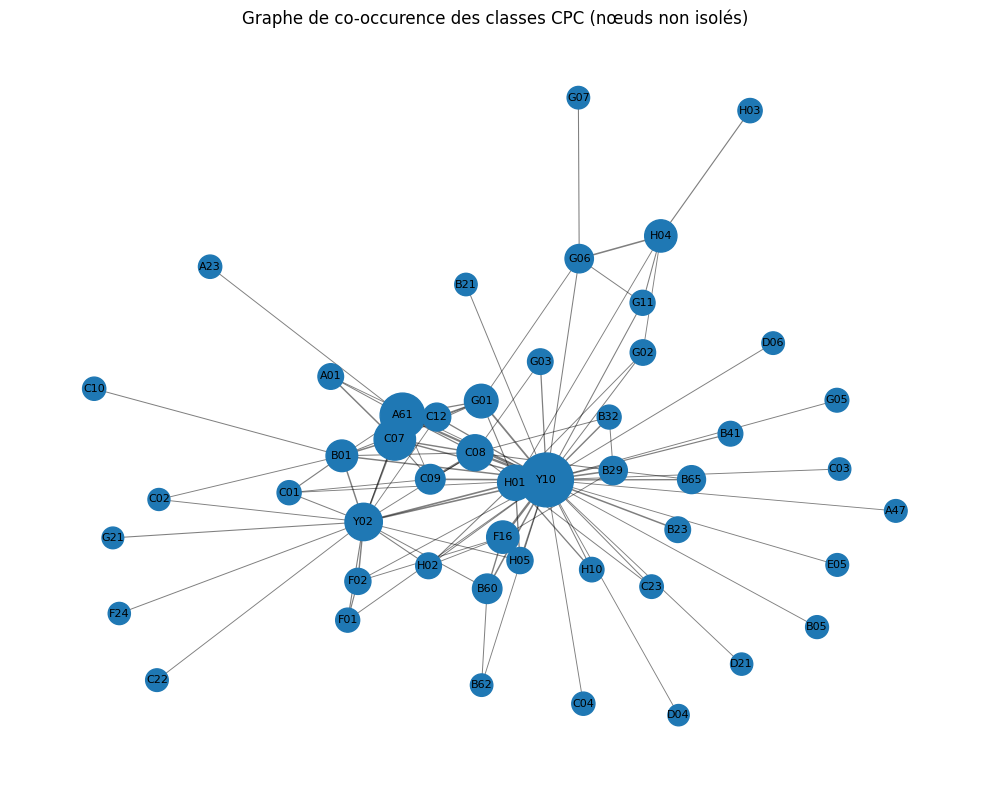

In [37]:
# Récupérer infos pour les tailles et poids
freqs = nx.get_node_attributes(G_main, "freq")
max_freq = max(freqs.values()) if freqs else 1
node_sizes = [200 + 1300 * (freqs[n] / max_freq) for n in G_main.nodes()]

weights = nx.get_edge_attributes(G_main, "weight")
max_w = max(weights.values()) if weights else 1
edge_widths = [0.5 + 3 * (weights[e] / max_w) for e in G_main.edges()]

# Layout
pos = nx.spring_layout(G_main, k=0.6, seed=0)

plt.figure(figsize=(10, 8))

nx.draw_networkx_nodes(G_main, pos, node_size=node_sizes)
nx.draw_networkx_edges(G_main, pos, width=edge_widths, alpha=0.5)
nx.draw_networkx_labels(G_main, pos, font_size=8)

plt.title("Graphe de co-occurence des classes CPC (nœuds non isolés)")
plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

weights = nx.get_edge_attributes(G_main, "weight")

min_w = min(weights.values())
max_w = max(weights.values())

print("poids min / max :", min_w, max_w)

# échelle logarithmique
edge_widths = []
for e in G_main.edges():
    w = weights[e]
    width = 1 + 4 * np.log1p(w)   # log(1+w), pour compresser la dynamique
    edge_widths.append(width)



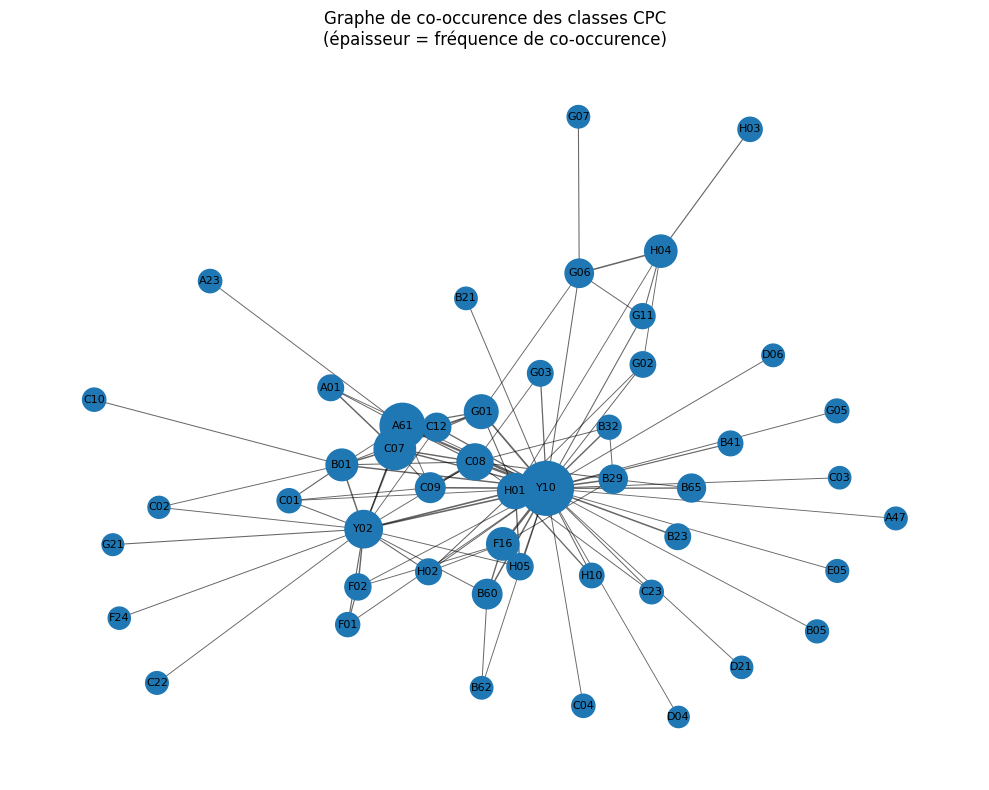

In [38]:
freqs = nx.get_node_attributes(G_main, "freq")
max_freq = max(freqs.values()) if freqs else 1
node_sizes = [200 + 1300 * (freqs[n] / max_freq) for n in G_main.nodes()]

pos = nx.spring_layout(G_main, k=0.6, seed=0)

plt.figure(figsize=(10, 8))

nx.draw_networkx_nodes(G_main, pos, node_size=node_sizes)
nx.draw_networkx_edges(G_main, pos, width=edge_widths, alpha=0.6)
nx.draw_networkx_labels(G_main, pos, font_size=8)

plt.title("Graphe de co-occurence des classes CPC\n(épaisseur = fréquence de co-occurence)")
plt.axis("off")
plt.tight_layout()
plt.show()


In [39]:
import pandas as pd

pd.Series(list(weights.values())).describe()


count      103.000000
mean      1374.728155
std       1315.717945
min        503.000000
25%        643.000000
50%        931.000000
75%       1800.500000
max      11126.000000
dtype: float64

In [40]:
# on transforme les poids en largeurs catégorielles
import pandas as pd
import numpy as np

weights = nx.get_edge_attributes(G_main, "weight")

# On regarde la distribution (tu l’as déjà fait, mais je le remets pour contexte)
w_series = pd.Series(list(weights.values()))
print(w_series.describe())

# On découpe en quantiles pour créer des classes
q50, q75, q90, q95 = w_series.quantile([0.5, 0.75, 0.90, 0.95])
print("Quantiles :", q50, q75, q90, q95)

def width_from_weight(w):
    if w <= q50:
        return 0.5   # les plus faibles
    elif w <= q75:
        return 1.5
    elif w <= q90:
        return 3
    elif w <= q95:
        return 5
    else:
        return 8     # les top co-occurrences

edge_widths = [width_from_weight(weights[e]) for e in G_main.edges()]

print("Largeurs utilisées :", sorted(set(edge_widths)))


count      103.000000
mean      1374.728155
std       1315.717945
min        503.000000
25%        643.000000
50%        931.000000
75%       1800.500000
max      11126.000000
dtype: float64
Quantiles : 931.0 1800.5 2437.3999999999996 3438.9999999999955
Largeurs utilisées : [0.5, 1.5, 3, 5, 8]


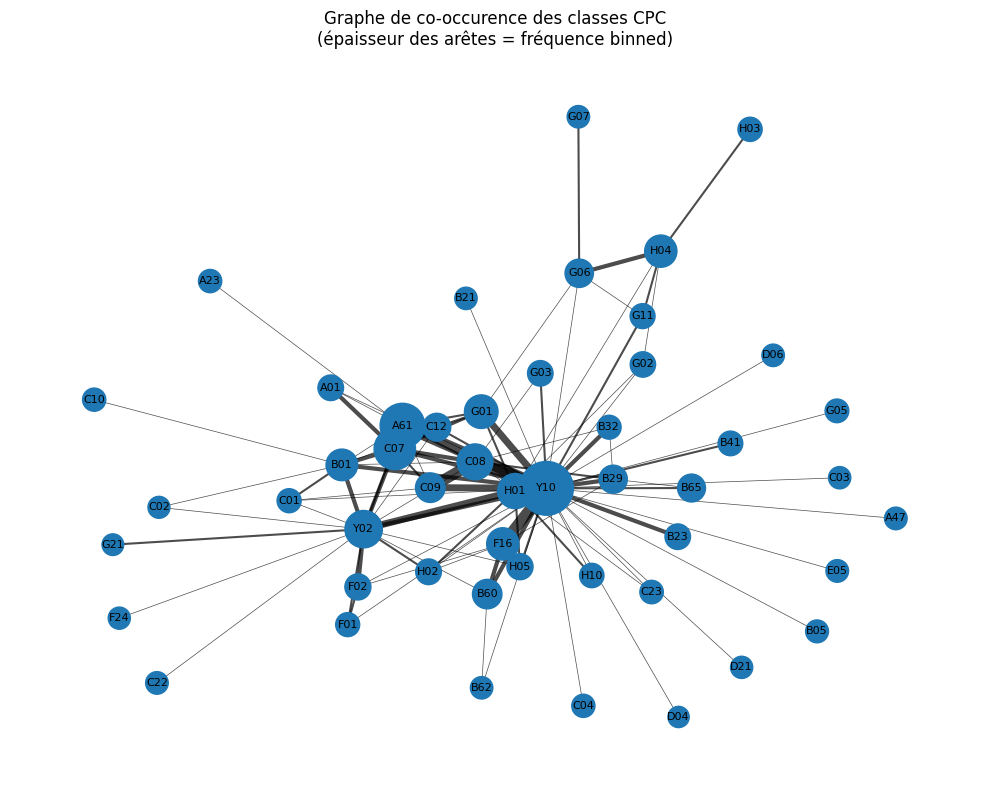

In [41]:
freqs = nx.get_node_attributes(G_main, "freq")
max_freq = max(freqs.values()) if freqs else 1
node_sizes = [200 + 1300 * (freqs[n] / max_freq) for n in G_main.nodes()]

pos = nx.spring_layout(G_main, k=0.6, seed=0)

plt.figure(figsize=(10, 8))

nx.draw_networkx_nodes(G_main, pos, node_size=node_sizes)
nx.draw_networkx_edges(G_main, pos, width=edge_widths, alpha=0.7)
nx.draw_networkx_labels(G_main, pos, font_size=8)

plt.title("Graphe de co-occurence des classes CPC\n(épaisseur des arêtes = fréquence binned)")
plt.axis("off")
plt.tight_layout()
plt.show()


In [42]:
import matplotlib.pyplot as plt

# --- 1) Construire la liste des couleurs d'arêtes ---

edge_colors = []
for u, v in G_main.edges():
    # on regarde la première lettre des classes CPC (ex: 'A61' -> 'A')
    letter_u = str(u)[0]
    letter_v = str(v)[0]
    
    if letter_u == letter_v:
        edge_colors.append("C0")   # même lettre de départ
    else:
        edge_colors.append("C1")   # lettres différentes


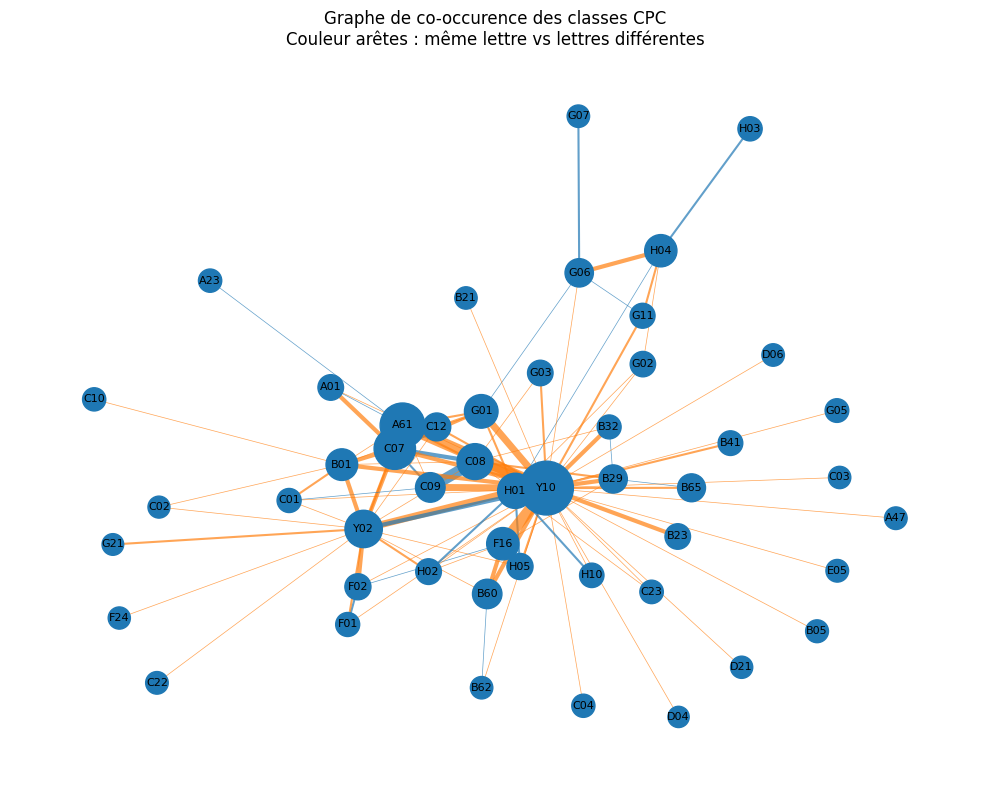

In [43]:
freqs = nx.get_node_attributes(G_main, "freq")
max_freq = max(freqs.values()) if freqs else 1
node_sizes = [200 + 1300 * (freqs[n] / max_freq) for n in G_main.nodes()]

pos = nx.spring_layout(G_main, k=0.6, seed=0)

plt.figure(figsize=(10, 8))

# nœuds
nx.draw_networkx_nodes(G_main, pos, node_size=node_sizes)

# arêtes : largeur = edge_widths, couleur = edge_colors
nx.draw_networkx_edges(
    G_main,
    pos,
    width=edge_widths,
    edge_color=edge_colors,
    alpha=0.7,
)

# labels
nx.draw_networkx_labels(G_main, pos, font_size=8)

plt.title("Graphe de co-occurence des classes CPC\n"
          "Couleur arêtes : même lettre vs lettres différentes")
plt.axis("off")
plt.tight_layout()
plt.show()


In [44]:
# sous forme de camembert
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === 1) On part de la matrice de co-occurrence existante ===
# cooccurrence : DataFrame carrée (classes × classes)

# Option : garder uniquement les classes les plus fréquentes
# (diagonale = nb de brevets contenant la classe)
diag = np.diag(cooccurrence.values)
diag_series = pd.Series(diag, index=cooccurrence.index)

# On garde par exemple les 30 classes les plus fréquentes
N = 30
top_classes = diag_series.sort_values(ascending=False).head(N).index
cooc_sub = cooccurrence.loc[top_classes, top_classes]


In [45]:
# === 2) Position des codes CPC sur le cercle ===

classes = list(cooc_sub.index)
n = len(classes)

# angles régulièrement espacés entre 0 et 2π
angles = np.linspace(0, 2 * np.pi, n, endpoint=False)

# rayon du cercle
radius = 1.0

# pour chaque classe -> angle
angle_map = {cls: ang for cls, ang in zip(classes, angles)}


In [47]:
#2. Fonction utilitaire pour tracer un ruban entre deux codes On va tracer chaque lien comme une courbe de Bézier (ou approximation) entre les deux points sur le cercle.
def bezier_curve(p0, p1, control_radius=0.3, n_points=100):
    """
    Retourne une courbe (x, y) de Bézier quadratique entre p0 et p1
    avec un point de contrôle vers le centre.
    p0, p1 : (x, y)
    control_radius : plus petit -> ruban plus près du centre
    """
    p0 = np.array(p0)
    p1 = np.array(p1)
    # point de contrôle = vers le centre (0,0), à un rayon plus petit
    control = (p0 + p1) / 2
    control = control / np.linalg.norm(control) * control_radius

    t = np.linspace(0, 1, n_points)
    curve = (1 - t)[:, None] ** 2 * p0 + \
            2 * (1 - t)[:, None] * t[:, None] * control + \
            t[:, None] ** 2 * p1
    return curve[:, 0], curve[:, 1]


In [48]:
# === 3) Préparer les largeurs et couleurs des liens ===

# On récupère tous les poids (co-occurrences) hors diagonale
weights = []
edges = []

for i, ci in enumerate(classes):
    for j, cj in enumerate(classes):
        if j <= i:
            continue  # on garde seulement la moitié supérieure
        w = cooc_sub.loc[ci, cj]
        if w > 0:
            edges.append((ci, cj))
            weights.append(w)

weights = np.array(weights)

# échelle de largeurs (linéaire sur log pour écraser les très gros)
w_min, w_max = weights.min(), weights.max()
lw_min, lw_max = np.log1p(w_min), np.log1p(w_max)

edge_widths = []
edge_colors = []

for (ci, cj), w in zip(edges, weights):
    # largeur
    lw = np.log1p(w)
    width = 0.3 + 5.7 * (lw - lw_min) / (lw_max - lw_min)  # entre ~0.3 et 6
    edge_widths.append(width)

    # couleur : même lettre ou non
    if ci[0] == cj[0]:
        edge_colors.append("tab:blue")   # même lettre de départ
    else:
        edge_colors.append("tab:orange") # lettres différentes


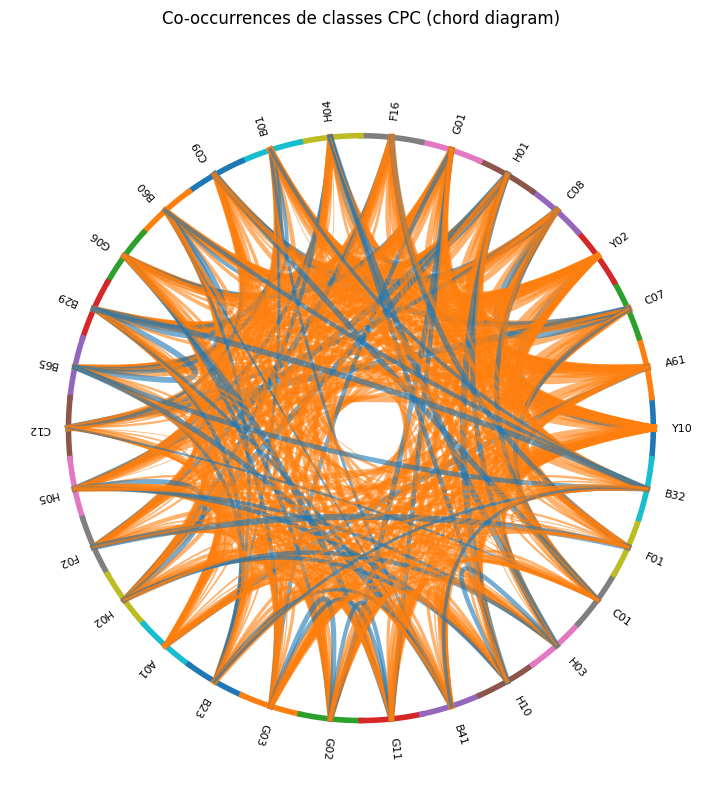

In [49]:
# === 4) Tracé du chord diagram ===

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# 4.1. Tracer les arcs sur le bord (codes CPC)
for cls, ang in angle_map.items():
    # petit arc autour de l'angle
    arc = np.linspace(ang - np.pi / n, ang + np.pi / n, 30)
    ax.plot(arc, [radius] * len(arc), linewidth=4)

    # label légèrement à l'extérieur
    ax.text(
        ang,
        radius + 0.1,
        cls,
        ha="center",
        va="center",
        rotation=np.degrees(ang),
        rotation_mode="anchor",
        fontsize=8,
    )

# 4.2. Tracer les rubans (co-occurrences)
for (ci, cj), width, color in zip(edges, edge_widths, edge_colors):
    ang_i = angle_map[ci]
    ang_j = angle_map[cj]

    # points sur le cercle
    x0, y0 = radius * np.cos(ang_i), radius * np.sin(ang_i)
    x1, y1 = radius * np.cos(ang_j), radius * np.sin(ang_j)

    # courbe de Bézier vers l'intérieur du cercle
    xs, ys = bezier_curve((x0, y0), (x1, y1), control_radius=0.2)

    # passer en coordonnées polaires pour tracer dans ax
    rs = np.sqrt(xs**2 + ys**2)
    thetas = np.arctan2(ys, xs)

    ax.plot(thetas, rs, linewidth=width, alpha=0.6, color=color)

# 4.3. Mise en forme
ax.set_axis_off()
ax.set_ylim(0, radius + 0.2)
plt.title("Co-occurrences de classes CPC (chord diagram)", pad=20)
plt.tight_layout()
plt.show()


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# cooccurrence : ta matrice carrée classes x classes

# 1) Fréquence de chaque classe (diagonale)
diag_series = pd.Series(
    np.diag(cooccurrence.values),
    index=cooccurrence.index,
    name="freq"
)

# 2) On garde les N classes les plus fréquentes
N = 40  # à ajuster (20–50 selon ce que tu veux)
top = diag_series.sort_values(ascending=False).head(N).index

# 3) On les réordonne par :
#   (a) première lettre (A,B,C,...)
#   (b) fréquence décroissante à l'intérieur de chaque lettre
ordered_classes = sorted(top, key=lambda c: (c[0], -diag_series[c]))

cooc_sub = cooccurrence.loc[ordered_classes, ordered_classes]


In [51]:
# Construire la série des co-occurrences sur la moitié supérieure
edges = []
weights = []

for i, ci in enumerate(ordered_classes):
    for j in range(i + 1, len(ordered_classes)):
        cj = ordered_classes[j]
        w = cooc_sub.loc[ci, cj]
        if w > 0:
            edges.append((ci, cj))
            weights.append(w)

w_series = pd.Series(weights, index=pd.MultiIndex.from_tuples(edges), name="w")

# Option A : garder seulement les K liens les plus forts
K = 150  # à ajuster
w_strong = w_series.sort_values(ascending=False).head(K)

# Option B (alternative) : garder les liens au-dessus d’un quantile
# q = 0.95
# w_strong = w_series[w_series >= w_series.quantile(q)]

edges_strong = list(w_strong.index)
weights_strong = w_strong.values


In [52]:
# Angles des classes sur le cercle (dans l’ordre choisi)
classes = ordered_classes
n = len(classes)
angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
radius = 1.0

angle_map = {cls: ang for cls, ang in zip(classes, angles)}

# Courbe de Bézier pour les rubans
def bezier_curve(p0, p1, control_radius=0.3, n_points=100):
    p0 = np.array(p0)
    p1 = np.array(p1)
    control = (p0 + p1) / 2
    control = control / np.linalg.norm(control) * control_radius
    t = np.linspace(0, 1, n_points)
    curve = ((1 - t)[:, None] ** 2 * p0
             + 2 * (1 - t)[:, None] * t[:, None] * control
             + t[:, None] ** 2 * p1)
    return curve[:, 0], curve[:, 1]


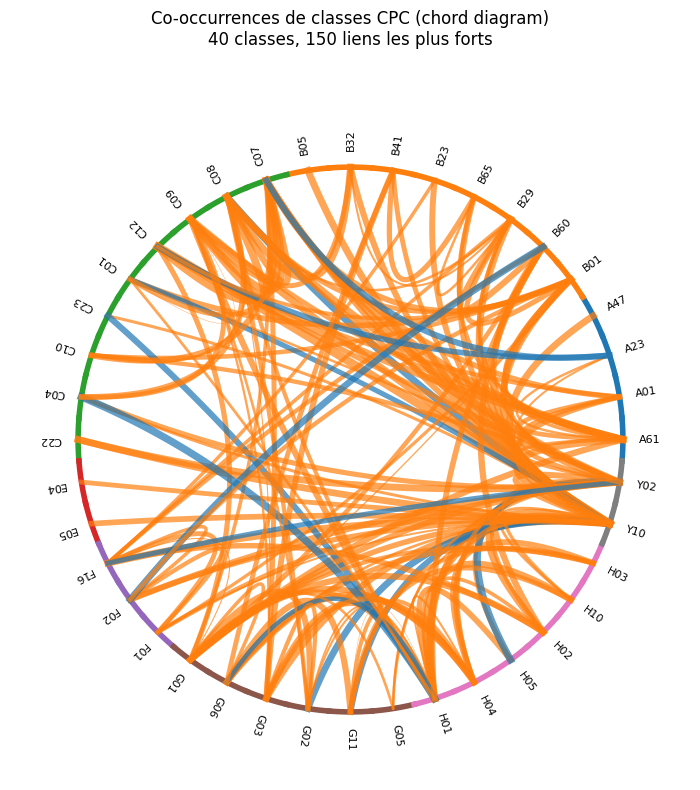

In [53]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Palette pour colorer les arcs par lettre (facultatif)
letters = sorted(set(c[0] for c in classes))
color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
letter_color = {
    L: color_cycle[i % len(color_cycle)]
    for i, L in enumerate(letters)
}

# 5.1. Arcs sur le bord (codes CPC)
for cls, ang in angle_map.items():
    L = cls[0]
    arc_color = letter_color[L]
    arc = np.linspace(ang - np.pi / n, ang + np.pi / n, 30)
    ax.plot(arc, [radius] * len(arc), linewidth=4, color=arc_color)

    ax.text(
        ang,
        radius + 0.1,
        cls,
        ha="center",
        va="center",
        rotation=np.degrees(ang),
        rotation_mode="anchor",
        fontsize=8,
    )

# 5.2. Rubans des co-occurrences (seulement les liens forts)
for (ci, cj), width, color in zip(edges_strong, edge_widths, edge_colors):
    ang_i = angle_map[ci]
    ang_j = angle_map[cj]

    x0, y0 = radius * np.cos(ang_i), radius * np.sin(ang_i)
    x1, y1 = radius * np.cos(ang_j), radius * np.sin(ang_j)

    xs, ys = bezier_curve((x0, y0), (x1, y1), control_radius=0.25)

    rs = np.sqrt(xs**2 + ys**2)
    thetas = np.arctan2(ys, xs)

    ax.plot(thetas, rs, linewidth=width, alpha=0.7, color=color)

# 5.3. Mise en forme
ax.set_axis_off()
ax.set_ylim(0, radius + 0.25)
plt.title(
    f"Co-occurrences de classes CPC (chord diagram)\n"
    f"{len(classes)} classes, {len(edges_strong)} liens les plus forts",
    pad=20,
)
plt.tight_layout()
plt.show()


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) fréquence de chaque classe = diagonale
diag_series = pd.Series(
    np.diag(cooccurrence.values),
    index=cooccurrence.index,
    name="freq"
)

# 2) garder les N classes les plus fréquentes
N = 40             # à ajuster (20–50 max)
top = diag_series.sort_values(ascending=False).head(N).index

# 3) les trier par lettre puis par fréquence décroissante dans la lettre
ordered_classes = sorted(top, key=lambda c: (c[0], -diag_series[c]))

cooc_sub = cooccurrence.loc[ordered_classes, ordered_classes]
classes   = ordered_classes
n         = len(classes)


In [55]:
# Construire toutes les co-occurrences (i<j)
edges = []
weights = []

for i, ci in enumerate(classes):
    for j in range(i + 1, len(classes)):
        cj = classes[j]
        w = cooc_sub.loc[ci, cj]
        if w > 0:
            edges.append((ci, cj))
            weights.append(w)

w_series = pd.Series(weights, index=pd.MultiIndex.from_tuples(edges), name="w")

# Garder les K liens les plus forts
K = 120                           # ajuste pour avoir plus / moins de liens
w_strong = w_series.sort_values(ascending=False).head(K)

edges_strong   = list(w_strong.index)
weights_strong = np.array(w_strong.values)


In [56]:
# Angles des classes sur le cercle (dans l’ordre choisi)
angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
radius = 1.0
angle_map = {cls: ang for cls, ang in zip(classes, angles)}

def bezier_curve(p0, p1, control_radius=0.3, n_points=100):
    """Courbe de Bézier quadratique entre p0 et p1, tirée vers le centre."""
    p0 = np.array(p0)
    p1 = np.array(p1)
    control = (p0 + p1) / 2
    control = control / np.linalg.norm(control) * control_radius
    t = np.linspace(0, 1, n_points)
    curve = ((1 - t)[:, None] ** 2 * p0
             + 2 * (1 - t)[:, None] * t[:, None] * control
             + t[:, None] ** 2 * p1)
    return curve[:, 0], curve[:, 1]


In [57]:
# On trie les liens forts du plus faible au plus fort pour leur donner des largeurs distinctes
order = np.argsort(weights_strong)     # indices triés par poids croissant
weights_sorted = weights_strong[order]
edges_sorted   = [edges_strong[i] for i in order]

# Rangs entre 0 et 1
ranks = np.linspace(0, 1, len(weights_sorted))

# Largeur entre 0.5 et 8 (bien contrasté)
edge_widths = 0.5 + 7.5 * ranks

# Couleurs selon une colormap continue (ex: OrRd)
cmap = plt.cm.OrRd
edge_colors = [cmap(r) for r in ranks]


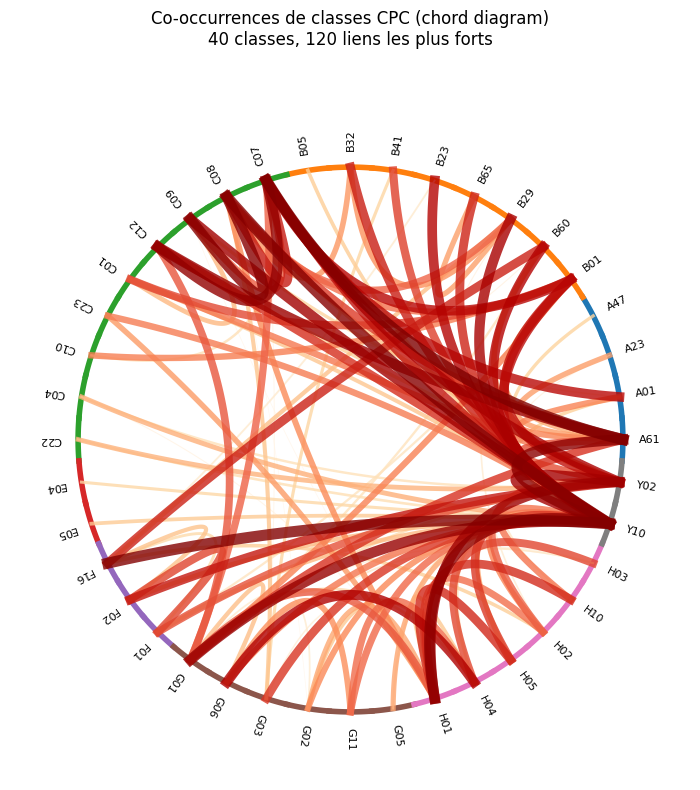

In [58]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Palette pour colorer les arcs (nœuds) par lettre (A,B,C,...)
letters = sorted(set(c[0] for c in classes))
color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
letter_color = {
    L: color_cycle[i % len(color_cycle)]
    for i, L in enumerate(letters)
}

# 5.1. Arcs sur le bord (codes CPC)
for cls, ang in angle_map.items():
    L = cls[0]
    arc_color = letter_color[L]
    arc = np.linspace(ang - np.pi / n, ang + np.pi / n, 30)
    ax.plot(arc, [radius] * len(arc), linewidth=4, color=arc_color)

    ax.text(
        ang,
        radius + 0.1,
        cls,
        ha="center",
        va="center",
        rotation=np.degrees(ang),
        rotation_mode="anchor",
        fontsize=8,
    )

# 5.2. Rubans = co-occurrences (uniquement les K plus fortes)
for (ci, cj), width, color in zip(edges_sorted, edge_widths, edge_colors):
    ang_i = angle_map[ci]
    ang_j = angle_map[cj]

    x0, y0 = radius * np.cos(ang_i), radius * np.sin(ang_i)
    x1, y1 = radius * np.cos(ang_j), radius * np.sin(ang_j)

    xs, ys = bezier_curve((x0, y0), (x1, y1), control_radius=0.25)

    rs = np.sqrt(xs**2 + ys**2)
    thetas = np.arctan2(ys, xs)

    ax.plot(thetas, rs, linewidth=width, alpha=0.8, color=color)

# 5.3. Mise en forme
ax.set_axis_off()
ax.set_ylim(0, radius + 0.25)
plt.title(
    f"Co-occurrences de classes CPC (chord diagram)\n"
    f"{len(classes)} classes, {len(edges_sorted)} liens les plus forts",
    pad=20,
)

plt.tight_layout()
plt.show()


In [59]:
# Top couples toutes classes
import pandas as pd
import numpy as np

pairs = []

classes = list(cooccurrence.index)

for i, ci in enumerate(classes):
    for j in range(i + 1, len(classes)):  # i<j pour ne pas doubler
        cj = classes[j]
        val = cooccurrence.iloc[i, j]
        if val > 0:  # on ignore les couples jamais observés
            pairs.append((ci, cj, val))

df_pairs = pd.DataFrame(pairs, columns=["cpc1", "cpc2", "count"])

# Top 30 couples de co-occurrence
top_pairs = df_pairs.sort_values("count", ascending=False).head(30)
top_pairs


,cpc1,cpc2,count
759,A61,C07,11126
4527,F16,Y10,4433
3479,C08,Y10,4407
3417,C08,C09,3977
827,A61,Y10,3781
4946,H01,Y10,3490
3364,C07,C12,2980
4762,G01,Y10,2810
764,A61,C12,2600
4944,H01,Y02,2526


In [ ]:
# distinction intra/inter domaines
df_pairs["same_letter"] = df_pairs["cpc1"].str[0] == df_pairs["cpc2"].str[0]

# Top couples intra-lettre
top_intra = (
    df_pairs[df_pairs["same_letter"]]
    .sort_values("count", ascending=False)
    .head(20)
)

# Top couples inter-lettres
top_inter = (
    df_pairs[~df_pairs["same_letter"]]
    .sort_values("count", ascending=False)
    .head(20)
)

top_intra, top_inter


(     cpc1 cpc2  count  same_letter
 3417  C08  C09   3977         True
 3364  C07  C12   2980         True
 4973  Y02  Y10   2371         True
 3360  C07  C08   1958         True
 4942  H01  H05   1702         True
 4943  H01  H10   1626         True
 4339  F01  F02   1210         True
 4954  H03  H04   1203         True
 3361  C07  C09   1017         True
 4837  G06  G07    970         True
 4939  H01  H02    935         True
 10    A01  A61    776         True
 2573  B60  B62    772         True
 4841  G06  G11    744         True
 2118  B29  B32    737         True
 199   A23  A61    694         True
 2129  B29  B65    680         True
 3092  C01  C09    626         True
 4745  G01  G06    599         True
 4376  F02  F16    583         True,
      cpc1 cpc2  count  same_letter
 759   A61  C07  11126        False
 4527  F16  Y10   4433        False
 3479  C08  Y10   4407        False
 827   A61  Y10   3781        False
 4946  H01  Y10   3490        False
 4762  G01  Y10   2810     

In [61]:
# pour les classes du chorus diagramm
subset = set(ordered_classes)

df_pairs_chord = df_pairs[
    df_pairs["cpc1"].isin(subset) & df_pairs["cpc2"].isin(subset)
]

top_pairs_chord = df_pairs_chord.sort_values("count", ascending=False).head(30)
top_pairs_chord


,cpc1,cpc2,count,same_letter
759,A61,C07,11126,False
4527,F16,Y10,4433,False
3479,C08,Y10,4407,False
3417,C08,C09,3977,True
827,A61,Y10,3781,False
4946,H01,Y10,3490,False
3364,C07,C12,2980,True
4762,G01,Y10,2810,False
764,A61,C12,2600,False
4944,H01,Y02,2526,False


In [62]:
# maintenant, on va utiliser des seuils de co-occurences pour bien voir les épaisseurs différentes des aretes
# === Nouvelle logique d'épaisseurs basées sur des seuils absolus ===

def width_from_threshold(w):
    if w < 1000:
        return 0.5
    elif w < 2000:
        return 2.0
    elif w < 4000:
        return 4.0
    else:  # w >= 4000
        return 6.0

def color_from_threshold(w):
    if w < 1000:
        return "#FEE5D9"   # très clair
    elif w < 2000:
        return "#FCAE91"   # claire
    elif w < 4000:
        return "#FB6A4A"   # rouge intermédiaire
    else:
        return "#CB181D"   # rouge très foncé

edge_widths = [width_from_threshold(w) for w in weights_strong]
edge_colors = [color_from_threshold(w) for w in weights_strong]


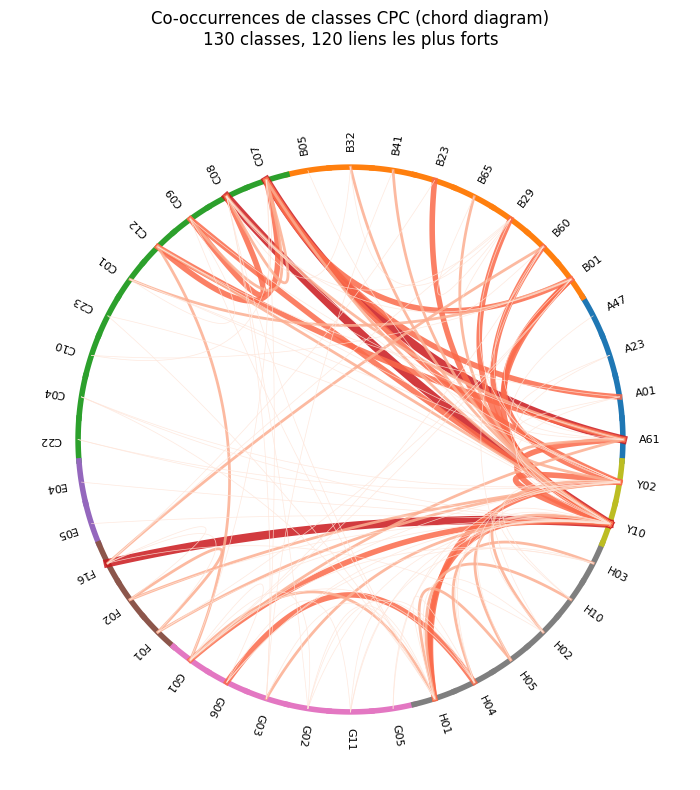

In [63]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Palette pour colorer les arcs (nœuds) par lettre (A,B,C,...)
letters = sorted(set(c[0] for c in classes))
color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
letter_color = {
    L: color_cycle[i % len(color_cycle)]
    for i, L in enumerate(letters)
}

# 5.1. Arcs sur le bord (codes CPC)
for cls, ang in angle_map.items():
    L = cls[0]
    arc_color = letter_color[L]
    arc = np.linspace(ang - np.pi / n, ang + np.pi / n, 30)
    ax.plot(arc, [radius] * len(arc), linewidth=4, color=arc_color)

    ax.text(
        ang,
        radius + 0.1,
        cls,
        ha="center",
        va="center",
        rotation=np.degrees(ang),
        rotation_mode="anchor",
        fontsize=8,
    )

# 5.2. Rubans = co-occurrences (uniquement les K plus fortes)
for (ci, cj), width, color in zip(edges_strong, edge_widths, edge_colors):
    ang_i = angle_map[ci]
    ang_j = angle_map[cj]

    x0, y0 = radius * np.cos(ang_i), radius * np.sin(ang_i)
    x1, y1 = radius * np.cos(ang_j), radius * np.sin(ang_j)

    xs, ys = bezier_curve((x0, y0), (x1, y1), control_radius=0.25)

    rs = np.sqrt(xs**2 + ys**2)
    thetas = np.arctan2(ys, xs)

    ax.plot(thetas, rs, linewidth=width, alpha=0.85, color=color)

# 5.3. Mise en forme
ax.set_axis_off()
ax.set_ylim(0, radius + 0.25)
plt.title(
    f"Co-occurrences de classes CPC (chord diagram)\n"
    f"{len(classes)} classes, {len(edges_sorted)} liens les plus forts",
    pad=20,
)

plt.tight_layout()
plt.show()
